In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PyEyeSim import EyeData

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
Path='C:/Users/nickp/Documents/Courses/P1&P2/EyeMovementDat/'
FilePath=Path+'test.csv'
FixData=pd.read_csv(FilePath, sep=',',header=0)
print(np.shape(FixData))

(7, 9)


In [6]:

sizeX,sizeY=100,100


DyslexiaDat=EyeData(FixData,sizeX,sizeY)
DyslexiaDat.DataInfo(mean_x='fix_x',mean_y='fix_y',FixDuration='duration_ms',Stimulus='stimfile',subjectID='sid')

dataset size:  (7, 9)
presentation size:  x= 100 pixels y= 100  pixels
presentation size:  x= 100 pixels y= 100  pixels
Stimulus  not found !!, provide column as Stimulus =YourColumn , default:  Stimulus
subjectID  not found !!, provide column as subjectID =YourColumn , default:  subjectID
mean_x  not found !!, provide column as mean_x =YourColumn , default:  mean_x
mean_y  not found !!, provide column as mean_y =YourColumn , default:  mean_y
info found for 1 subjects, and 1 stimuli
sizecorrect =  True ; If stimulus not full screen, assume central presentation, use correction
run descriptive analysis
Data for  1 observers and  1  stimuli.
Mean fixation number:  7.0  +/-  0.0
fixation duration not asked for
Num of trials with zero fixations: 0
Num valid trials  1
Mean X location:  46.4  +/-  0.0  pixels
Mean Y location:  41.4  +/-  0.0  pixels
Mean saccade  amplitude:  48.4  +/-  0.0  pixels
Mean scanpath  length:  290.2  +/-  0.0  pixels


C:\Users\nickp\Documents\GitHub\PyEyeSim\PyEyeSim\__init__.py:280: UserWarning: Stim path not provided
  warnings.warn("Stim path not provided")


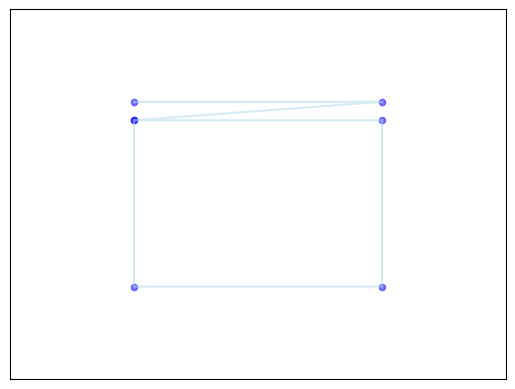

In [7]:
DyslexiaDat.VisScanPath(0,visFix=True,scan_path_col='lightblue', allS=0)

---

## ROI Features

In [ ]:
from PyEyeSim.scanpathsimhelper import CreatAoiRects
def SaccadeAndFeatures(self, SaccadeObj, nHor, stim, nVer=0, InferS=False):
    if nVer == 0:
        nVer = nHor  # if number of vertical divisions not provided, use same as horizontal

    SaccadeAOIAngles = []   # store angles per saccade per ROI cell (even if the saccade crosses multiple cells)
    SaccadeAOIAnglesCross = []  # for saccades that cross >1 ROI

    # Create AOI rectangles. Here we assume CreatAoiRects returns a nested structure,
    # e.g., AOIRects[stim][h][v] is an AOI rectangle object that has a .Cross(LinePoints) method.
    if InferS:
        if not hasattr(self, 'boundsX'):
            print('Running descriptives to get bounds')
            self.RunDescriptiveFix()  
        AOIRects = CreatAoiRects(nHor, nVer, self.boundsX, self.boundsY)
    else:
        AOIRects = CreatAoiRects(nHor, nVer, self.x_size, self.y_size, allsame=self.np)

    ns = self.ns  

    Saccades = np.zeros(((ns, nVer, nHor)), dtype=np.ndarray)  # Array of saccades crossing each AOI rectangle for each trial and participant
    for s in np.arange(self.ns):
        SaccadeAOIAngles.append(np.zeros((int(self.nsac[s, stim]), nVer, nHor)))
        SaccadeAOIAngles[s][:] = np.nan
        SaccadeAOIAnglesCross.append(np.zeros((int(self.nsac[s, stim]), nVer, nHor)))
        SaccadeAOIAnglesCross[s][:] = np.nan
        
        for sac in range(len(SaccadeObj[s][stim])):
            SaccadeDots = SaccadeObj[s][stim][sac].LinePoints()
            
            for h in range(nHor):
                for v in range(nVer):
                    if AOIRects[stim][h][v].Cross(SaccadeDots):
                        SaccadeAOIAngles[s][sac, v, h] = SaccadeObj[s][stim][sac].Angle()  # Get angle of the saccade
                                           

            # Select saccades that cross multiple cells
            if np.sum(SaccadeAOIAngles[s][sac, :, :] > 0) > 1:
                SaccadeAOIAnglesCross[s][sac, :, :] = SaccadeAOIAngles[s][sac, :, :]
            else:
                # search index of all the not nan values of SaccadeAOIAngles[s][p][sac,:,:]
                idxs = np.argwhere(~np.isnan(SaccadeAOIAngles[s][sac, :, :]))
                if len(idxs) > 0:
                    for idx in idxs:
                        v, h = idx
                        if isinstance(Saccades[s,v,h], np.ndarray):
                            Saccades[s,v,h]=np.append(Saccades[s,v,h],SaccadeAOIAngles[s][sac,v,h])
                        else:
                            Saccades[s,v,h]=np.array([SaccadeAOIAngles[s][sac,v,h]])

        # store saccades that cross multiple AOI rectangles
        for h in range(nHor):
            for v in range(nVer):
                if np.sum(np.isfinite(SaccadeAOIAnglesCross[s][:,v,h]))>0:
                    if isinstance(Saccades[s,v,h], np.ndarray):
                        Saccades[s,v,h]=np.append(Saccades[s,v,h],SaccadeAOIAnglesCross[s][~np.isnan(SaccadeAOIAnglesCross[s][:,v,h]),v,h])
                    else:
                        Saccades[s,v,h]=np.array(SaccadeAOIAnglesCross[s][~np.isnan(SaccadeAOIAnglesCross[s][:,v,h]),v,h])
                elif not isinstance(Saccades[s,v,h], np.ndarray):
                    Saccades[s,v,h]=np.array([])

    Features = np.empty((ns, nVer, nHor), dtype=object)
    for s in range(ns):
        cords = []
        for sac in range(len(SaccadeObj[s][stim])):
            x1,y1,x2,y2 = SaccadeObj[s][stim][sac].Coords()
            if cords == []:
                cords.append((x1,y1))
            else:
                cords.append((x1,y1))
        cords.append((x2,y2))
        for h in range(nVer):
            for v in range(nHor):
                angles = np.array(Saccades[s, v, h])
                
                # Mean and STD for angles (if there is any data)
                if angles.size > 0:
                    mean_angle = np.nanmean(angles)
                    std_angle = np.nanstd(angles)
                else:
                    mean_angle = np.nan
                    std_angle = np.nan

                #Count of fixations in the cell
                landing_first_fix = [np.nan, np.nan]
                fixation_count = 0
                duration = np.array([])
                for x,y in cords:
                    if AOIRects[stim][h][v].Contains(x,y):
                        if fixation_count == 0:
                            landing_first_fix = [x,y]
                        fixation_count += 1
                        # self.data[['subjectID','duration','mean_x','mean_y']]
                        # check fixation duration where subjectID = DyslexiaDat.subjects[s] and mean_x, mean_y are within the AOI
                        duration = np.append(duration, self.data.loc[(self.data['subjectID'] == self.subjects[s]) & (self.data['mean_x'] == x) & (self.data['mean_y'] == y)]['duration'].values)

                # Number of revisits – incoming saccades hitting this ROI from outside
                revisits = 0
                exits = False
                for sac in range(len(SaccadeObj[s][stim])):
                    x1,y1,x2,y2 = SaccadeObj[s][stim][sac].Coords()
                    if AOIRects[stim][h][v].Contains(x1,y1) and not AOIRects[stim][h][v].Contains(x2,y2):
                        exits = True
                    if not AOIRects[stim][h][v].Contains(x1,y1) and AOIRects[stim][h][v].Contains(x2,y2) and exits:
                        revisits += 1

                Features[s, v, h] = {'mean_angle': mean_angle,
                                        'std_angle': std_angle,
                                        'fixation_count': fixation_count,
                                        'mean_fixation_duration': np.nanmean(duration),
                                        'number_of_revisits': revisits,
                                        'landing_first_fix_x': landing_first_fix[0],
                                        'landing_first_fix_y': landing_first_fix[1]
                                        }
                
    return Saccades, Features

In [12]:
SaccadeObj = DyslexiaDat.GetSaccades()
Saccades, Features = SaccadeAndFeatures(DyslexiaDat, SaccadeObj, nHor=4, stim=0, nVer=4, InferS=False)

[1]
[1 2]
[1 2]
[1]
[1]
[1]
[1]


C:\Users\nickp\AppData\Local\Temp\ipykernel_14236\158634676.py:111: RuntimeWarning: Mean of empty slice
  'mean_fixation_duration': np.nanmean(duration),


In [10]:
print(Features)

[[[{'mean_angle': nan, 'std_angle': nan, 'fixation_count': 0, 'mean_fixation_duration': nan, 'number_of_revisits': 0, 'landing_first_fix_x': nan, 'landing_first_fix_y': nan}
   {'mean_angle': nan, 'std_angle': nan, 'fixation_count': 0, 'mean_fixation_duration': nan, 'number_of_revisits': 0, 'landing_first_fix_x': nan, 'landing_first_fix_y': nan}
   {'mean_angle': nan, 'std_angle': nan, 'fixation_count': 0, 'mean_fixation_duration': nan, 'number_of_revisits': 0, 'landing_first_fix_x': nan, 'landing_first_fix_y': nan}
   {'mean_angle': nan, 'std_angle': nan, 'fixation_count': 0, 'mean_fixation_duration': nan, 'number_of_revisits': 0, 'landing_first_fix_x': nan, 'landing_first_fix_y': nan}]
  [{'mean_angle': nan, 'std_angle': nan, 'fixation_count': 0, 'mean_fixation_duration': nan, 'number_of_revisits': 0, 'landing_first_fix_x': nan, 'landing_first_fix_y': nan}
   {'mean_angle': 111.07235171562509, 'std_angle': 73.3630153447977, 'fixation_count': 3, 'mean_fixation_duration': 1.4, 'number_

---

## Whole task Features


In [43]:
DyslexiaDat.x_size

100

In [45]:
from scipy.stats import entropy
def get_entropy(self, subj, stim):
    # get fixation (array([x]), array([y]))
    fixations = DyslexiaDat.GetFixationData(DyslexiaDat.subjects[subj], DyslexiaDat.stimuli[stim])
    # calculate entropy of the fixation distribution
    sizeX = self.x_size
    sizeY = self.y_size
    x = fixations[0].tolist()
    y = fixations[1].tolist()
    # create a 2D histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=(sizeX, sizeY))
    # normalize the histogram
    H = H / H.sum()
    # calculate entropy
    ent = entropy(H.flatten())
    return ent

In [44]:
def GlobalFeature(self, stim):
    Features = np.empty((self.ns), dtype=object)
    for s in range(self.ns):
        angles = []
        progressive_s = 0
        regressive_s = 0
        for saccade in self.GetSaccades()[s][stim]:
            angles.append(saccade.Angle())
            if saccade.Angle() > 270 or saccade.Angle() < 90:
                progressive_s += 1
            elif saccade.Angle() > 90 and saccade.Angle() < 270:
                regressive_s += 1
        
        fix_durations = DyslexiaDat.GetDurations(DyslexiaDat.subjects[s], DyslexiaDat.stimuli[stim])

        Features[s] = {'number_fixation':  self.nfixations[s][stim],
                       'fixation_entropy': get_entropy(self, s, stim),
                       'mean_fixation_duration': np.mean(fix_durations),
                       'std_fixation_duration': np.std(fix_durations),
                       'total_reading_duration': np.sum(fix_durations),
                       'mean_saccade_amplitude': np.mean(angles),
                       'std_saccade_amplitude': np.std(angles),
                       'regression': regressive_s,
                       'progression/regression': np.nan if regressive_s == 0 else progressive_s/regressive_s
                        }
    return Features  

In [46]:
GlobalFeature(DyslexiaDat, 0)

array([{'number_fixation': 7.0, 'fixation_entropy': 1.7478680974667575, 'mean_fixation_duration': 1.0, 'std_fixation_duration': 0.0, 'total_reading_duration': 7, 'mean_saccade_amplitude': 119.04823447708338, 'std_saccade_amplitude': 98.94603289320432, 'regression': 2, 'progression/regression': 1.0}],
      dtype=object)